In [1]:
# If you need any of these, uncomment and run once.
%pip install -U pandas numpy scikit-learn matplotlib wordcloud nltk textstat
%pip install -U imbalanced-learn joblib tqdm
%pip install -U sentence-transformers
%pip install -U transformers accelerate peft datasets
%pip install -U lightgbm xgboost shap


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os, re, json, time, math, random, warnings
from pathlib import Path
from typing import Optional, Dict, List, Tuple

import numpy as np
import pandas as pd

from tqdm.auto import tqdm

# Sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, f1_score,
                             precision_recall_fscore_support, roc_auc_score)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.utils.class_weight import compute_class_weight

# Viz
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# NLP utils
import nltk, textstat
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Optional libs (handled gracefully)
try:
    import shap
    HAS_SHAP = True
except Exception:
    HAS_SHAP = False

try:
    from sentence_transformers import SentenceTransformer
    HAS_ST = True
except Exception:
    HAS_ST = False

# Transformers (for DL model)
try:
    import torch
    from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                              TrainingArguments, Trainer, DataCollatorWithPadding, EarlyStoppingCallback)
    HAS_TRANSFORMERS = True
except Exception:
    HAS_TRANSFORMERS = False

SEED = 42
random.seed(SEED); np.random.seed(SEED)
os.environ.setdefault("TOKENIZERS_PARALLELISM", "false")
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.90")
os.environ.setdefault("PYTORCH_MPS_LOW_WATERMARK_RATIO", "0.50")

# NLTK setup
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def ts():
    return time.strftime("%Y%m%d_%H%M%S")

BASE_DIR = Path.cwd()
DATA_DIR_CANDIDATES = [
    BASE_DIR / "CUAD_v1" / "label_group_xlsx",
    BASE_DIR / "data" / "CUAD_V1" / "label_group_xlsx",
    BASE_DIR / "label_group_xlsx"
]

# Regex to detect filenames in bad text cols
_FILENAME_LIKE_RE = re.compile(r"""(?i)(?:^|/)[\w\-\.]+\.(?:pdf|docx?|txt|xlsx|pptx?)$""")


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def looks_like_filename_series(s: pd.Series) -> pd.Series:
    return s.astype(str).str.contains(_FILENAME_LIKE_RE, regex=True, na=False)

def pick_text_column(df: pd.DataFrame) -> Optional[str]:
    cols = [c for c in df.columns if c.lower() != "filename"]
    object_cols = [c for c in cols if pd.api.types.is_object_dtype(df[c])]
    if "ClauseText" in object_cols:
        object_cols = ["ClauseText"] + [c for c in object_cols if c != "ClauseText"]

    choices = []
    for c in object_cols:
        series = df[c].astype(str)
        series = series[~looks_like_filename_series(series)].str.strip()
        med = 0 if series.empty else series.str.len().median()
        choices.append((med, c))
    choices.sort(reverse=True)
    return choices[0][1] if choices else None

def clean_category_from_filename(p: Path) -> str:
    name = p.stem
    if name.lower().startswith("label report - "):
        name = name[len("Label Report - "):]
    name = re.sub(r"\s*\(Group\s*\d+\)\s*$", "", name).strip()
    name = name.replace("_", " ")
    name = re.sub(r"\s{2,}", " ", name)
    return name

def load_cuad_xlsx(label_dir: Path) -> pd.DataFrame:
    rows = []
    xlsx_files = sorted(label_dir.glob("*.xlsx"))
    if not xlsx_files:
        raise FileNotFoundError(f"No XLSX files found under: {label_dir}")

    for p in xlsx_files:
        try:
            df = pd.read_excel(p)
        except Exception as e:
            print(f"[WARN] Skipping {p.name}: {e}")
            continue

        df.columns = [re.sub(r"\s+", " ", c.strip()) for c in df.columns]

        file_col = None
        for cand in ["Filename", "File Name", "File"]:
            if cand in df.columns:
                file_col = cand
                break
        if file_col is None:
            candidates = []
            for c in df.columns:
                s = df[c].astype(str)
                ratio = looks_like_filename_series(s).mean()
                candidates.append((ratio, c))
            candidates.sort(reverse=True)
            file_col = candidates[0][1]

        text_col = pick_text_column(df)
        if not text_col:
            obj_cols = [c for c in df.columns if pd.api.types.is_object_dtype(df[c])]
            if not obj_cols:
                continue
            text_col = obj_cols[0]

        category = clean_category_from_filename(p)

        part = df[[file_col, text_col]].copy()
        part.columns = ["Filename", "ClauseText"]
        part["ClauseText"] = part["ClauseText"].astype(str).str.strip()

        # Filter
        part = part[~looks_like_filename_series(part["ClauseText"])]
        part = part[part["ClauseText"].str.len() >= 30]

        part["Category"] = category
        if len(part):
            print(f"[XLSX] {p.name} → rows={len(part):<5}  text_col='{text_col}'  file_col='{file_col}'  category='{category}'")
        rows.append(part)

    if not rows:
        raise RuntimeError("No usable rows parsed from XLSX files.")

    all_df = pd.concat(rows, ignore_index=True)
    all_df.drop_duplicates(subset=["Filename", "ClauseText", "Category"], inplace=True)
    return all_df

def resolve_label_dir(custom_dir: Optional[str]=None) -> Path:
    if custom_dir:
        d = Path(custom_dir).expanduser()
        return d if d.name.lower()=="label_group_xlsx" else (d/"label_group_xlsx")
    for c in DATA_DIR_CANDIDATES:
        if c.is_dir() and any(c.glob("*.xlsx")):
            print(f"[paths] Using label_dir: {c}")
            return c
    raise FileNotFoundError("No label_group_xlsx found in common locations.")


In [4]:
# If your data folder is not auto-detected, set it explicitly:
# LABEL_DIR = resolve_label_dir("/path/to/data/CUAD_V1")

from pathlib import Path

# use absolute or verified path
LABEL_DIR = Path("/Users/sruthynath/Mac Docs/MPSTME/LTIM/data/CUAD_V1/label_group_xlsx")
df_raw = load_cuad_xlsx(LABEL_DIR)
print(f"Loaded {len(df_raw)} rows across {df_raw['Category'].nunique()} categories.")
df_raw.sample(5, random_state=SEED)


[XLSX] Label Report - Anti-assignment, CIC (Group 3).xlsx → rows=374    text_col='Anti-assignment'  file_col='Filename'  category='Anti-assignment, CIC'
[XLSX] Label Report - Audit Rights.xlsx → rows=214    text_col='Audit Rights'  file_col='Filename'  category='Audit Rights'
[XLSX] Label Report - Covenant not to Sue_ Release of Claims.xlsx → rows=100    text_col='Covenant not to Sue'  file_col='Filename'  category='Covenant not to Sue Release of Claims'
[XLSX] Label Report - Dates (Group 1).xlsx → rows=412    text_col='Expiration Date'  file_col='Filename'  category='Dates'
[XLSX] Label Report - Document Name.xlsx → rows=426    text_col='Document Name'  file_col='Filename'  category='Document Name'
[XLSX] Label Report - Governing Law.xlsx → rows=437    text_col='Governing Law'  file_col='Filename'  category='Governing Law'
[XLSX] Label Report - IP Ownership Assignment.xlsx → rows=124    text_col='IP Ownership Assignment'  file_col='Filename'  category='IP Ownership Assignment'
[XLSX] 

,Filename,ClauseText,Category
1210,CoherusBiosciencesInc_20200227_10-K_EX-10.29_1...,LICENSE AND DEVELOPMENT AGREEMENT (Page 3),Document Name
2029,IVILLAGEINC_03_17_1999-EX-10.16-SPONSORSHIP AG...,"Upon execution and delivery of this Agreement,...",IP Ownership Assignment
3979,IMMUNOMEDICSINC_08_07_2019-EX-10.1-PROMOTION A...,In partial consideration of Company‚Äôs Promot...,Revenue-Profit Sharing
3729,"ETELOS,INC_03_09_2004-EX-10.8-DISTRIBUTOR AGRE...","Upon termination of this Agreement, Distributo...",Post-Termination Services
3704,ENERGOUSCORP_03_16_2017-EX-10.24-STRATEGIC ALL...,Upon the termination of DIALOG’s right to manu...,Post-Termination Services


Categories: 28
Category
Parties                        509
Governing Law                  437
Document Name                  426
Dates                          412
Anti-assignment, CIC           374
Uncapped Liability             275
Licenses                       255
Audit Rights                   214
Termination for Convenience    183
Post-Termination Services      182
Name: count, dtype: int64
           len_char     len_word
count   4719.000000  4719.000000
mean     624.677898    97.471922
std      940.479474   144.707427
min       30.000000     4.000000
25%      160.000000    26.000000
50%      314.000000    50.000000
75%      707.000000   110.000000
max    15545.000000  2612.000000
count    4719.000000
mean       21.414807
std        35.349861
min      -311.747945
25%         4.597208
50%        25.795000
75%        43.604050
max       106.246667
Name: readability_fre, dtype: float64


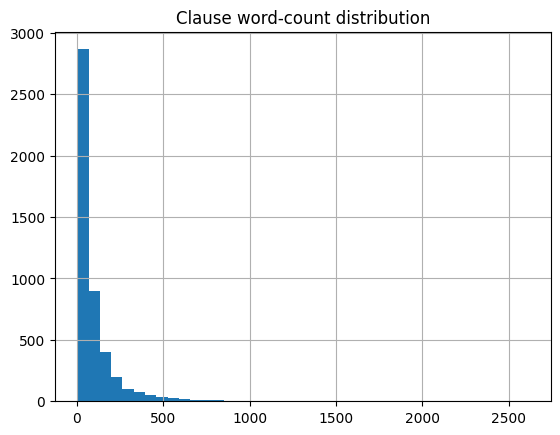

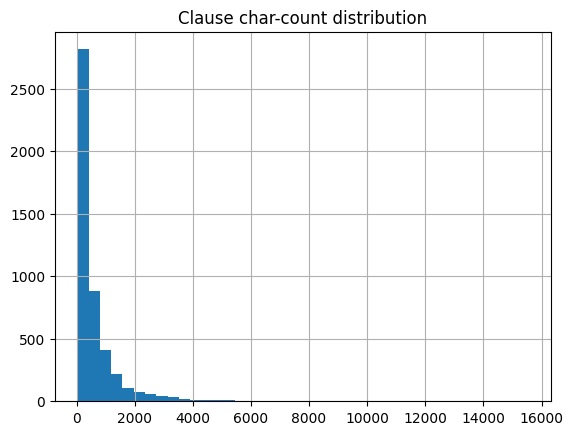

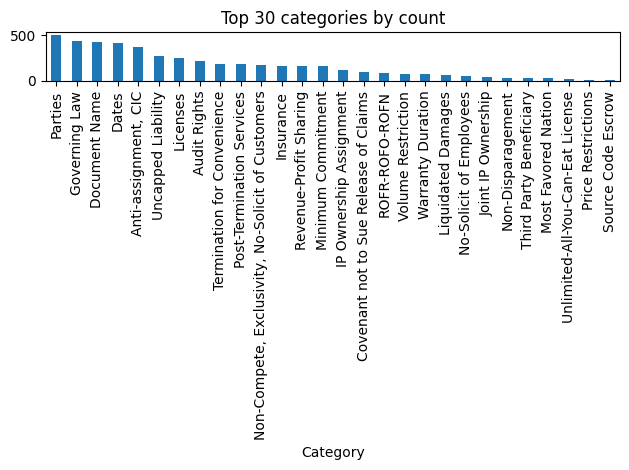

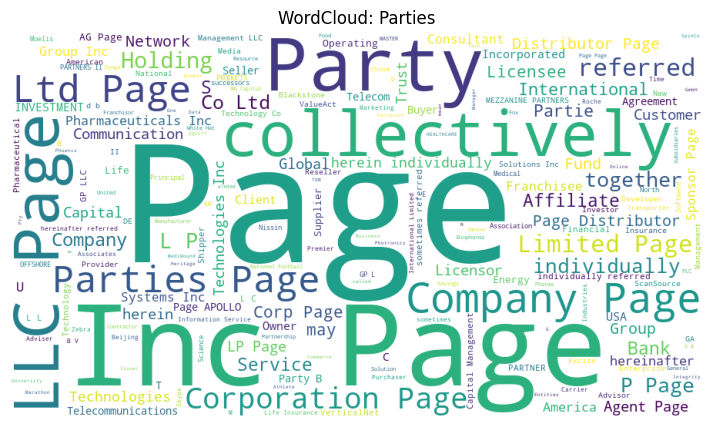

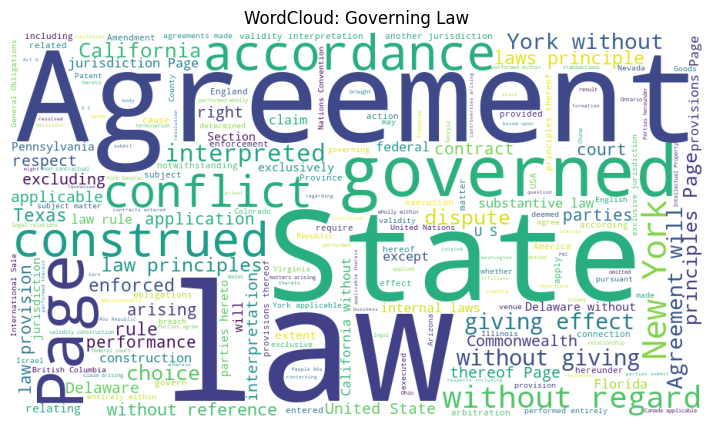

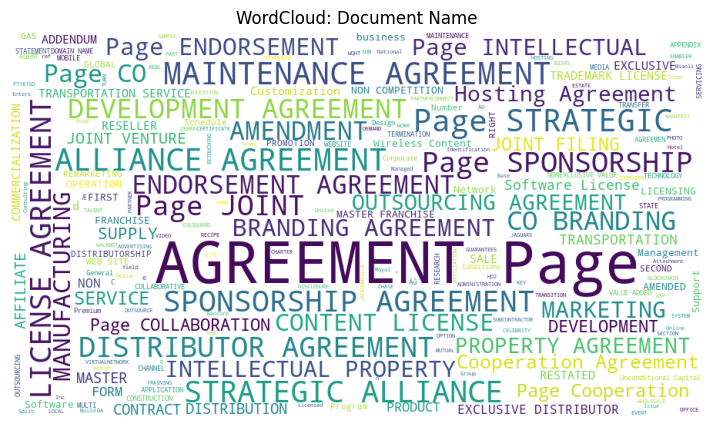

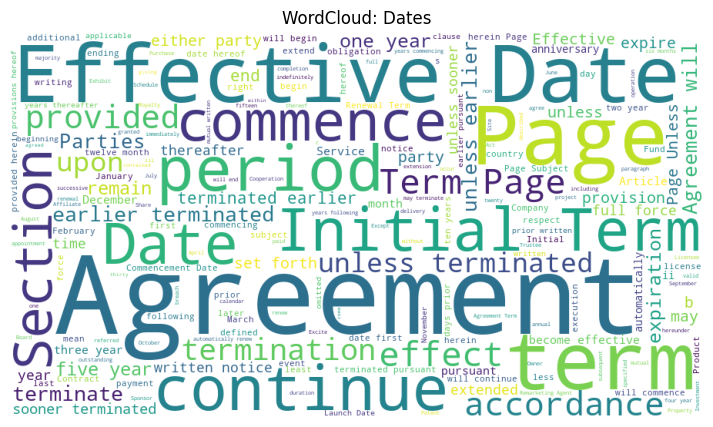

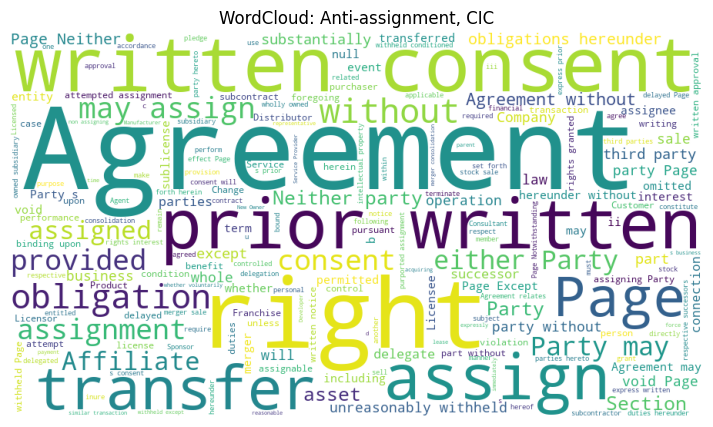

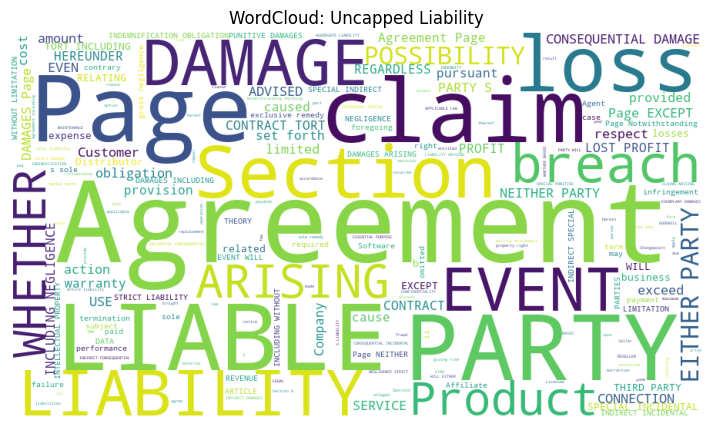


Top ngrams for Parties:
page                           2569
inc                            485
inc page                       468
company                        166
party                          149
parties                        142
llc                            141
collectively                   135
llc page                       132
company page                   129
ltd                            115
ltd page                       111
parties page                   106
corporation                    106
corporation page               97

Top ngrams for Governing Law:
laws                           632
agreement                      482
page                           449
state                          426
shall                          403
governed                       393
laws state                     318
accordance                     296
shall governed                 281
construed                      280
agreement shall                264
accordance laws                227

In [5]:
# Basic stats
print("Categories:", df_raw["Category"].nunique())
print(df_raw["Category"].value_counts().head(10))

# Text length
df_raw["len_char"] = df_raw["ClauseText"].str.len()
df_raw["len_word"] = df_raw["ClauseText"].str.split().str.len()

print(df_raw[["len_char","len_word"]].describe())

# Readability (Flesch Reading Ease)
def safe_fre(s):
    try:
        return textstat.flesch_reading_ease(s)
    except Exception:
        return np.nan

df_raw["readability_fre"] = df_raw["ClauseText"].head(5000).apply(safe_fre)  # cap for speed
print(df_raw["readability_fre"].describe())

# Plot distributions (will show if running in Jupyter)
plt.figure()
df_raw["len_word"].hist(bins=40)
plt.title("Clause word-count distribution")
plt.show()

plt.figure()
df_raw["len_char"].hist(bins=40)
plt.title("Clause char-count distribution")
plt.show()

# Per-class counts
vc = df_raw["Category"].value_counts()
plt.figure()
vc.head(30).plot(kind="bar")
plt.title("Top 30 categories by count")
plt.tight_layout()
plt.show()

# Word cloud per top 6 classes
top_classes = vc.head(6).index.tolist()
for c in top_classes:
    text = " ".join(df_raw.loc[df_raw["Category"]==c, "ClauseText"].tolist())
    wc = WordCloud(width=900, height=500, background_color="white").generate(text)
    plt.figure(figsize=(9,5))
    plt.imshow(wc)
    plt.axis("off")
    plt.title(f"WordCloud: {c}")
    plt.show()

# Quick n-gram explorer (TF counts)
def top_ngrams(texts, ngram_range=(1,2), topk=20, stop=STOPWORDS):
    vec = TfidfVectorizer(lowercase=True, stop_words=list(stop), ngram_range=ngram_range, use_idf=False, norm=None)
    X = vec.fit_transform(texts)
    freqs = np.asarray(X.sum(axis=0)).ravel()
    idx = freqs.argsort()[::-1][:topk]
    feats = np.array(vec.get_feature_names_out())[idx]
    vals = freqs[idx]
    return list(zip(feats, vals))

for c in top_classes:
    pairs = top_ngrams(df_raw.loc[df_raw["Category"]==c, "ClauseText"].tolist(), (1,2), 15)
    print(f"\nTop ngrams for {c}:")
    for w,f in pairs:
        print(f"{w:30s} {int(f)}")


In [6]:
URL_RE = re.compile(r'https?://\S+|www\.\S+')
EMAIL_RE = re.compile(r'\b[\w\.-]+@[\w\.-]+\.\w{2,4}\b')
NUM_RE = re.compile(r'\b\d+(\.\d+)?\b')

def normalize_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub(' ', s)
    s = EMAIL_RE.sub(' ', s)
    s = NUM_RE.sub(' ', s)
    s = re.sub(r'[^a-z\s]+', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

def preprocess_for_ml(s: str) -> str:
    s = normalize_text(s)
    tokens = [lemmatizer.lemmatize(t) for t in s.split() if t not in STOPWORDS and len(t)>2]
    return " ".join(tokens)

df = df_raw.copy()
df["text_clean"] = df["ClauseText"].apply(preprocess_for_ml)

print(df[["ClauseText","text_clean"]].head(3).to_string(index=False))


                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              ClauseText                                                                                                                                                                                                                                                                                                                                

In [7]:
le = LabelEncoder()
df["label"] = le.fit_transform(df["Category"])
id2label = {i:l for i,l in enumerate(le.classes_)}
label2id = {v:k for k,v in id2label.items()}

train_df, test_df = train_test_split(df, test_size=0.10, random_state=SEED, stratify=df["label"])
train_df, val_df  = train_test_split(train_df, test_size=0.1111, random_state=SEED, stratify=train_df["label"])  # ~10% of original

print(len(train_df), len(val_df), len(test_df), "classes=", len(id2label))

classes = np.unique(train_df["label"])
class_weights = compute_class_weight('balanced', classes=classes, y=train_df["label"])
cw_dict = {i:w for i,w in zip(classes, class_weights)}
cw_dict


3775 472 472 classes= 28


{np.int64(0): np.float64(0.4494047619047619),
 np.int64(1): np.float64(0.7838455149501661),
 np.int64(2): np.float64(1.6852678571428572),
 np.int64(3): np.float64(0.40854978354978355),
 np.int64(4): np.float64(0.39653361344537813),
 np.int64(5): np.float64(0.38630781825624233),
 np.int64(6): np.float64(1.3482142857142858),
 np.int64(7): np.float64(1.0213744588744589),
 np.int64(8): np.float64(3.7450396825396823),
 np.int64(9): np.float64(0.6608893557422969),
 np.int64(10): np.float64(2.751457725947522),
 np.int64(11): np.float64(1.0213744588744589),
 np.int64(12): np.float64(6.128246753246753),
 np.int64(13): np.float64(2.8685410334346506),
 np.int64(14): np.float64(0.9362599206349206),
 np.int64(15): np.float64(4.494047619047619),
 np.int64(16): np.float64(0.33125658125658125),
 np.int64(17): np.float64(0.9234344422700587),
 np.int64(18): np.float64(11.235119047619047),
 np.int64(19): np.float64(1.9826680672268908),
 np.int64(20): np.float64(1.0213744588744589),
 np.int64(21): np.floa

In [8]:
# Variant A: TF-IDF (word + char)
tfidf_word = TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_char = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=3, max_df=0.9)

# Variant B: Sentence embeddings (optional)
ST_MODEL = "sentence-transformers/all-MiniLM-L12-v2"
st_model = SentenceTransformer(ST_MODEL) if HAS_ST else None

def embed_sentences(texts: List[str]) -> np.ndarray:
    if not HAS_ST:
        raise RuntimeError("sentence-transformers not installed.")
    return st_model.encode(texts, batch_size=64, show_progress_bar=True, normalize_embeddings=True)


In [9]:
Xtr, ytr = train_df["text_clean"].tolist(), train_df["label"].values
Xva, yva = val_df["text_clean"].tolist(), val_df["label"].values
Xte, yte = test_df["text_clean"].tolist(), test_df["label"].values

def evaluate_model(name, clf, Xtr, ytr, Xva, yva, Xte, yte, label_names):
    # Fit
    clf.fit(Xtr, ytr)
    # Evaluate
    def eval_split(X, y, split_name):
        yp = clf.predict(X)
        rep = classification_report(y, yp, target_names=label_names, digits=4, output_dict=True)
        acc = accuracy_score(y, yp)
        f1m = f1_score(y, yp, average="macro")
        print(f"{name} [{split_name}] acc={acc:.4f} macro_f1={f1m:.4f}")
        return rep, acc, f1m

    rep_tr, acc_tr, f1_tr = eval_split(Xtr, ytr, "train")
    rep_va, acc_va, f1_va = eval_split(Xva, yva, "val")
    rep_te, acc_te, f1_te = eval_split(Xte, yte, "test")

    return {
        "name": name,
        "train_acc": acc_tr, "train_f1m": f1_tr,
        "val_acc": acc_va, "val_f1m": f1_va,
        "test_acc": acc_te, "test_f1m": f1_te,
        "val_report": rep_va, "test_report": rep_te
    }

# Pipelines
pipe_lr = Pipeline([
    ("tfidf", tfidf_word),
    ("svd", TruncatedSVD(n_components=300, random_state=SEED)),
    ("clf", LogisticRegression(max_iter=2000, class_weight="balanced", solver="saga"))
])
grid_lr = {
    "tfidf__min_df": [2,3,5],
    "svd__n_components": [200,300,400],
    "clf__C": [0.5, 1.0, 2.0]
}

pipe_svc = Pipeline([
    ("tfidf", tfidf_word),
    ("svd", TruncatedSVD(n_components=300, random_state=SEED)),
    ("clf", LinearSVC())
])
grid_svc = {
    "tfidf__min_df": [2,3,5],
    "svd__n_components": [200,300,400],
    "clf__C": [0.5, 1.0, 2.0]
}

pipe_nb = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2)),
    ("clf", MultinomialNB())
])
grid_nb = {
    "tfidf__min_df": [2,3,5],
    "clf__alpha": [0.3, 0.7, 1.0]
}

pipe_rf = Pipeline([
    ("tfidf", tfidf_word),
    ("svd", TruncatedSVD(n_components=300, random_state=SEED)),
    ("clf", RandomForestClassifier(n_estimators=400, n_jobs=-1, class_weight="balanced"))
])
grid_rf = {
    "svd__n_components": [200,300],
    "clf__n_estimators": [300,500],
    "clf__max_depth": [None, 20, 40]
}

models_grids = [
    ("LogReg_TFIDF_SVD", pipe_lr, grid_lr),
    ("LinearSVC_TFIDF_SVD", pipe_svc, grid_svc),
    ("MultinomialNB_TFIDF", pipe_nb, grid_nb),
    ("RandomForest_TFIDF_SVD", pipe_rf, grid_rf),
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

results = []
best_pipelines = {}

for name, pipe, grid in models_grids:
    print(f"\n### HPO: {name}")
    search = GridSearchCV(
        pipe, grid, scoring="f1_macro", cv=cv, n_jobs=-1, verbose=1, refit=True
    )
    search.fit(Xtr, ytr)
    print("Best params:", search.best_params_, "CV best f1_macro:", search.best_score_)
    best_pipelines[name] = search.best_estimator_
    res = evaluate_model(name, search.best_estimator_, Xtr, ytr, Xva, yva, Xte, yte, le.classes_)
    res["best_params"] = search.best_params_
    results.append(res)

df_results = pd.DataFrame([{
    "model": r["name"],
    "train_f1_macro": r["train_f1m"],
    "val_f1_macro": r["val_f1m"],
    "test_f1_macro": r["test_f1m"],
    "val_acc": r["val_acc"],
    "test_acc": r["test_acc"],
    "best_params": r["best_params"]
} for r in results]).sort_values("val_f1_macro", ascending=False)

df_results



### HPO: LogReg_TFIDF_SVD
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/py

Best params: {'clf__C': 2.0, 'svd__n_components': 300, 'tfidf__min_df': 3} CV best f1_macro: 0.7603461788655054
LogReg_TFIDF_SVD [train] acc=0.9208 macro_f1=0.8650
LogReg_TFIDF_SVD [val] acc=0.8898 macro_f1=0.7629
LogReg_TFIDF_SVD [test] acc=0.8750 macro_f1=0.7965

### HPO: LinearSVC_TFIDF_SVD
Fitting 5 folds for each of 27 candidates, totalling 135 fits


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precis

Best params: {'clf__C': 2.0, 'svd__n_components': 300, 'tfidf__min_df': 5} CV best f1_macro: 0.7706431366006804
LinearSVC_TFIDF_SVD [train] acc=0.9703 macro_f1=0.9488
LinearSVC_TFIDF_SVD [val] acc=0.8962 macro_f1=0.7715
LinearSVC_TFIDF_SVD [test] acc=0.8941 macro_f1=0.8064

### HPO: MultinomialNB_TFIDF
Fitting 5 folds for each of 9 candidates, totalling 45 fits


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

Best params: {'clf__alpha': 0.3, 'tfidf__min_df': 5} CV best f1_macro: 0.5709093896611414


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

MultinomialNB_TFIDF [train] acc=0.9293 macro_f1=0.7737
MultinomialNB_TFIDF [val] acc=0.8242 macro_f1=0.5503
MultinomialNB_TFIDF [test] acc=0.8369 macro_f1=0.6196

### HPO: RandomForest_TFIDF_SVD
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best params: {'clf__max_depth': 20, 'clf__n_estimators': 500, 'svd__n_components': 200} CV best f1_macro: 0.6793249236486041
RandomForest_TFIDF_SVD [train] acc=0.9939 macro_f1=0.9931
RandomForest_TFIDF_SVD [val] acc=0.8220 macro_f1=0.6523
RandomForest_TFIDF_SVD [test] acc=0.8559 macro_f1=0.6898


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

,model,train_f1_macro,val_f1_macro,test_f1_macro,val_acc,test_acc,best_params
1,LinearSVC_TFIDF_SVD,0.948762,0.771490,0.806408,0.896186,0.894068,"{'clf__C': 2.0, 'svd__n_components': 300, 'tfi..."
0,LogReg_TFIDF_SVD,0.864973,0.762946,0.796454,0.889831,0.875000,"{'clf__C': 2.0, 'svd__n_components': 300, 'tfi..."
3,RandomForest_TFIDF_SVD,0.993078,0.652324,0.689767,0.822034,0.855932,"{'clf__max_depth': 20, 'clf__n_estimators': 50..."
2,MultinomialNB_TFIDF,0.773664,0.550277,0.619599,0.824153,0.836864,"{'clf__alpha': 0.3, 'tfidf__min_df': 5}"


In [10]:
# Take top-2 pipelines from df_results for a soft/hard voting (if compatible)
top2 = df_results["model"].head(2).tolist()
print("Top-2:", top2)
voters = []
for m in top2:
    voters.append((m, best_pipelines[m]))

# Note: LinearSVC has no predict_proba → use hard voting
ensemble = VotingClassifier(estimators=voters, voting="hard")
ensemble.fit(Xtr, ytr)
for split_name, X, y in [("val", Xva, yva), ("test", Xte, yte)]:
    yp = ensemble.predict(X)
    print(f"[Ensemble-hard] {split_name}", "acc=", accuracy_score(y, yp), "f1_macro=", f1_score(y, yp, average="macro"))


Top-2: ['LinearSVC_TFIDF_SVD', 'LogReg_TFIDF_SVD']
[Ensemble-hard] val acc= 0.8919491525423728 f1_macro= 0.768922232354846
[Ensemble-hard] test acc= 0.885593220338983 f1_macro= 0.7969443711658509


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [11]:
%pip install --upgrade --no-cache-dir torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0
%pip install --upgrade --no-cache-dir transformers safetensors


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [12]:
BASE_MODEL = "nlpaueb/legal-bert-base-uncased"  # or "distilbert-base-uncased"

if HAS_TRANSFORMERS:
    device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
    print("Torch:", torch.__version__, "Device:", device)

    tok = AutoTokenizer.from_pretrained(BASE_MODEL, use_fast=True)

    class HFDS(torch.utils.data.Dataset):
        def __init__(self, df, max_length=256):
            self.texts = df["ClauseText"].tolist()
            self.labels = df["label"].astype(int).tolist()
            self.max_length = max_length
        def __len__(self): return len(self.texts)
        def __getitem__(self, idx):
            enc = tok(
                self.texts[idx],
                truncation=True, padding="max_length", max_length=self.max_length,
                return_tensors="pt"
            )
            item = {k: v.squeeze(0) for k, v in enc.items()}
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

    train_ds = HFDS(train_df, max_length=256)
    val_ds   = HFDS(val_df, max_length=256)
    test_ds  = HFDS(test_df, max_length=256)

    model = AutoModelForSequenceClassification.from_pretrained(
        BASE_MODEL, num_labels=len(id2label), id2label=id2label, label2id=label2id
    )

    args = TrainingArguments(
        output_dir=str(BASE_DIR / "hf_runs" / f"{ts()}"),
        learning_rate=2e-5,
        per_device_train_batch_size=8,
        per_device_eval_batch_size=8,
        num_train_epochs=2,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_f1_macro",
        report_to="none",
        remove_unused_columns=False,
        gradient_accumulation_steps=1,
        dataloader_num_workers=0,
        bf16=(torch.cuda.is_available()),
        fp16=False,  # fp16 on MPS not supported by Accelerate
        seed=SEED
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = logits.argmax(axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro")
        }

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tok,
        data_collator=DataCollatorWithPadding(tok),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    # Evaluate
    def eval_trainer(ds, split="test"):
        out = trainer.predict(ds)
        y_true = out.label_ids
        y_pred = out.predictions.argmax(-1)
        rep = classification_report(y_true, y_pred, target_names=le.classes_, digits=4)
        print(f"\n[HF {split}]")
        print(rep)
        return rep

    rep_val_hf = eval_trainer(val_ds, "val")
    rep_test_hf = eval_trainer(test_ds, "test")

else:
    print("Transformers not available; skipping deep model.")


Torch: 2.6.0 Device: mps


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1181928195.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro
1,No log,0.583516,0.891949,0.697531
2,1.294400,0.424666,0.900424,0.752136



[HF val]
                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     0.9730    0.9730    0.9730        37
                                     Audit Rights     1.0000    0.9524    0.9756        21
            Covenant not to Sue Release of Claims     0.9000    0.9000    0.9000        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     1.0000    1.0000    1.0000        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.5556    0.8333    0.6667        12
                                        Insurance     0.8947    1.0000    0.9444        17
                               Joint IP Ownership     0.0000    0.0000    0.0000         5
                                         Licenses     0.7059    0.9600    0.813

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 


[HF test]
                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     0.9737    1.0000    0.9867        37
                                     Audit Rights     0.9545    1.0000    0.9767        21
            Covenant not to Sue Release of Claims     1.0000    0.9000    0.9474        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     1.0000    1.0000    1.0000        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.6875    0.9167    0.7857        12
                                        Insurance     0.9444    1.0000    0.9714        17
                               Joint IP Ownership     0.0000    0.0000    0.0000         5
                                         Licenses     0.7273    0.9231    0.81

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

Best classical model: LinearSVC_TFIDF_SVD
Confusion matrix shape: (28, 28)


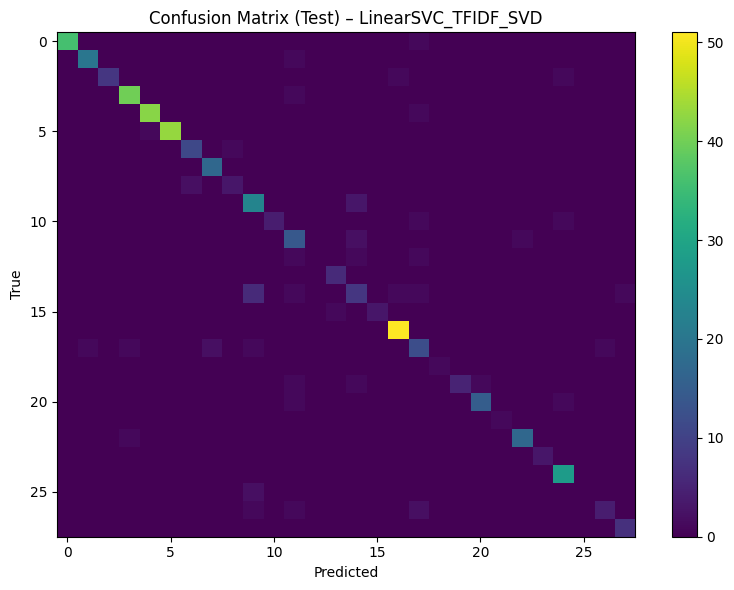

Bottom-10 classes by F1:
Most Favored Nation                       0.000
Unlimited-All-You-Can-Eat License         0.000
Non-Compete, Exclusivity, No-Solicit of Customers  0.485
Volume Restriction                        0.615
Post-Termination Services                 0.649
Joint IP Ownership                        0.667
Minimum Commitment                        0.737
ROFR-ROFO-ROFN                            0.769
Licenses                                  0.780
Liquidated Damages                        0.800


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

,text,true,pred
0,Sponsor hereby agrees to and does (a) waive an...,Covenant not to Sue Release of Claims,Uncapped Liability
1,The initial term of this Agreement shall be fo...,Termination for Convenience,Dates
2,Royalty payments are payable from THI to Marv ...,Revenue-Profit Sharing,Minimum Commitment
3,The license hereby granted shall be exclusive ...,"Non-Compete, Exclusivity, No-Solicit of Customers",Licenses
4,"In this regard, it is specifically understood ...","Non-Compete, Exclusivity, No-Solicit of Customers",Parties
5,Upon termination of this Agreement for reasons...,Most Favored Nation,Post-Termination Services
6,If the Reseller sells less than 50% of any yea...,Minimum Commitment,Termination for Convenience
7,Except as otherwise expressly provided in theB...,Audit Rights,Minimum Commitment
8,In the event PAPA JOHN’S wishes to sub-contrac...,"Anti-assignment, CIC",Post-Termination Services
9,The Professional grants to the Company the exc...,Licenses,"Non-Compete, Exclusivity, No-Solicit of Customers"


In [13]:
# Pick best classical based on val_f1
best_name = df_results.iloc[0]["model"]
best_clf = best_pipelines[best_name]
print("Best classical model:", best_name)

# Confusion matrix on test
y_pred_test = best_clf.predict(Xte)
cm = confusion_matrix(yte, y_pred_test)
print("Confusion matrix shape:", cm.shape)

plt.figure(figsize=(8,6))
plt.imshow(cm, aspect='auto')
plt.title(f"Confusion Matrix (Test) – {best_name}")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

# Show hardest classes (lowest F1)
rep = classification_report(yte, y_pred_test, target_names=le.classes_, digits=4, output_dict=True)
per_class = [(c, rep[c]["f1-score"]) for c in le.classes_ if c in rep]
print("Bottom-10 classes by F1:")
for c, f1c in sorted(per_class, key=lambda x: x[1])[:10]:
    print(f"{c:40s}  {f1c:.3f}")

# Inspect some mistakes
err_idx = np.where(y_pred_test != yte)[0]
sample_err = np.random.default_rng(SEED).choice(err_idx, size=min(15, len(err_idx)), replace=False)
err_table = pd.DataFrame({
    "text": [test_df["ClauseText"].iloc[i] for i in sample_err],
    "true": [id2label[int(yte[i])] for i in sample_err],
    "pred": [id2label[int(y_pred_test[i])] for i in sample_err]
})
err_table.head(10)


In [14]:
if HAS_SHAP and "LogReg" in best_name:
    # fit a clone on combined train+val to explain on test
    from sklearn.base import clone
    explainer_clf = clone(best_clf)
    explainer_clf.fit(pd.concat([train_df["text_clean"], val_df["text_clean"]]).tolist(),
                      np.concatenate([ytr, yva]))
    try:
        # KernelExplainer on TF-IDF space is expensive; we do a small subset
        import shap
        background = test_df["text_clean"].sample(40, random_state=SEED).tolist()
        test_small = test_df["text_clean"].sample(25, random_state=SEED).tolist()
        # Use shap.Explainer on predict_proba when available
        if hasattr(explainer_clf, "predict_proba"):
            f = lambda X: explainer_clf.predict_proba(X)
        else:
            f = lambda X: np.eye(len(id2label))[explainer_clf.predict(X)]
        explainer = shap.Explainer(f, explainer_clf.named_steps["tfidf"])
        shap_values = explainer(test_small)
        shap.plots.bar(shap_values, max_display=12)
        plt.show()
    except Exception as e:
        print("SHAP failed or too heavy in this environment:", e)
else:
    print("SHAP skipped (not available or model not probabilistic).")


SHAP skipped (not available or model not probabilistic).


In [15]:
from joblib import dump
ART_DIR = BASE_DIR / "outputs_clause_classifier" / ts()
ART_DIR.mkdir(parents=True, exist_ok=True)

# Save the classical best pipeline
dump(best_clf, ART_DIR / "best_classical_pipeline.joblib")
with open(ART_DIR / "label_mapping.json", "w") as f:
    json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)

# Save comparison table
df_results.to_csv(ART_DIR / "model_comparison.csv", index=False)

print("Saved classical model + artifacts →", ART_DIR)

# Save the DL model if trained
if HAS_TRANSFORMERS and 'trainer' in globals():
    HF_DIR = ART_DIR / "hf_model"
    HF_DIR.mkdir(parents=True, exist_ok=True)
    trainer.save_model(HF_DIR)
    tok.save_pretrained(HF_DIR)
    with open(HF_DIR / "label_mapping.json", "w") as f:
        json.dump({"id2label": id2label, "label2id": label2id}, f, indent=2)
    print("Saved HF model →", HF_DIR)


Saved classical model + artifacts → /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_clause_classifier/20251012_225759
Saved HF model → /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_clause_classifier/20251012_225759/hf_model


In [16]:
# Load classical pipeline and predict on new clauses
from joblib import load

def load_classical_model_artifacts(art_dir: Path):
    clf = load(art_dir / "best_classical_pipeline.joblib")
    mapping = json.loads((art_dir / "label_mapping.json").read_text())
    id2lbl = {int(k):v for k,v in mapping["id2label"].items()}
    return clf, id2lbl

def classify_clauses(clauses: List[str], clf, id2lbl: Dict[int,str]):
    # If your pipeline starts with TF-IDF that expects cleaned text,
    # but we trained with text_clean input, pass through same preprocessing:
    texts = [preprocess_for_ml(c) for c in clauses]
    preds = clf.predict(texts)
    return [id2lbl[int(p)] for p in preds]

# Example:
# clf_loaded, id2lbl_loaded = load_classical_model_artifacts(ART_DIR)
# classify_clauses(["This Agreement shall be governed by the laws of ..."], clf_loaded, id2lbl_loaded)


In [17]:
try:
    import xgboost as xgb
    use_xgb = True
except Exception:
    use_xgb = False

if use_xgb:
    pipe_xgb = Pipeline([
        ("tfidf", tfidf_word),
        ("svd", TruncatedSVD(n_components=300, random_state=SEED)),
        ("clf", xgb.XGBClassifier(
            objective="multi:softprob",
            eval_metric="mlogloss",
            tree_method="hist",
            n_estimators=600,
            random_state=SEED
        ))
    ])
    grid_xgb = {
        "svd__n_components": [200,300,400],
        "clf__max_depth": [4,6,8],
        "clf__learning_rate": [0.05, 0.1],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.7, 1.0],
    }
    print("\n### HPO: XGBoost_TFIDF_SVD")
    search_xgb = RandomizedSearchCV(
        pipe_xgb, grid_xgb, scoring="f1_macro", cv=cv, n_iter=12, n_jobs=-1, random_state=SEED, verbose=1
    )
    search_xgb.fit(Xtr, ytr)
    res_xgb = evaluate_model("XGBoost_TFIDF_SVD", search_xgb.best_estimator_,
                             Xtr, ytr, Xva, yva, Xte, yte, le.classes_)
else:
    print("XGBoost not installed; skipping.")



### HPO: XGBoost_TFIDF_SVD
Fitting 5 folds for each of 12 candidates, totalling 60 fits
XGBoost_TFIDF_SVD [train] acc=0.9939 macro_f1=0.9930
XGBoost_TFIDF_SVD [val] acc=0.8411 macro_f1=0.6788
XGBoost_TFIDF_SVD [test] acc=0.8665 macro_f1=0.7335


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

In [18]:
final_rows = [df_results.iloc[0].to_dict()]
if HAS_TRANSFORMERS and 'rep_test_hf' in globals():
    # Extract HF macro-F1 approximations from text report if needed; here we just print earlier
    final_rows[0]["HF_present"] = True
else:
    final_rows[0]["HF_present"] = False

pd.DataFrame(final_rows)


,model,train_f1_macro,val_f1_macro,test_f1_macro,val_acc,test_acc,best_params,HF_present
0,LinearSVC_TFIDF_SVD,0.948762,0.77149,0.806408,0.896186,0.894068,"{'clf__C': 2.0, 'svd__n_components': 300, 'tfi...",True


In [19]:
# Candidate transformer backbones
TRANSFORMER_MODELS = [
    "nlpaueb/legal-bert-base-uncased",  # legal domain
    "bert-base-uncased",                # strong baseline
    "roberta-base",                     # often robust on text cls
    "distilbert-base-uncased",          # fast
    "microsoft/deberta-v3-base"         # powerful general CLS
]


TRAIN_CONFIG = dict(
    max_len=256,
    lr=2e-5,
    epochs=3,
    batch_size=8,
)


In [20]:
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    Trainer, TrainingArguments, DataCollatorWithPadding, EarlyStoppingCallback
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    classification_report, confusion_matrix
)
import torch, numpy as np, pandas as pd
from pathlib import Path

def train_eval_transformer(model_name, train_df, val_df, test_df, id2label, label2id,
                           max_len=256, lr=2e-5, epochs=3, batch_size=8):

    print(f"\n🚀 Training {model_name}")
    device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
    tok = AutoTokenizer.from_pretrained(model_name, use_fast=True)
    num_labels = len(id2label)
    model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,
                                                               id2label=id2label, label2id=label2id)

    class HFDS(torch.utils.data.Dataset):
        def __init__(self, df):
            self.texts = df["ClauseText"].tolist()
            self.labels = df["label"].astype(int).tolist()
        def __len__(self): return len(self.texts)
        def __getitem__(self, idx):
            enc = tok(self.texts[idx], truncation=True, padding="max_length",
                      max_length=max_len, return_tensors="pt")
            item = {k: v.squeeze(0) for k, v in enc.items()}
            item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
            return item

    train_ds, val_ds, test_ds = HFDS(train_df), HFDS(val_df), HFDS(test_df)

    args = TrainingArguments(
        output_dir=f"./runs/{model_name.split('/')[-1]}",
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        learning_rate=lr,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_dir="./logs",
        report_to="none",
        dataloader_num_workers=0,
        seed=42
    )

    def compute_metrics(eval_pred):
        logits, labels = eval_pred
        preds = np.argmax(logits, axis=-1)
        return {
            "accuracy": accuracy_score(labels, preds),
            "f1_macro": f1_score(labels, preds, average="macro"),
            "precision_macro": precision_score(labels, preds, average="macro"),
            "recall_macro": recall_score(labels, preds, average="macro"),
        }

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tok,
        data_collator=DataCollatorWithPadding(tok),
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=1)]
    )

    trainer.train()

    # Final evaluation
    val_pred = trainer.predict(val_ds)
    test_pred = trainer.predict(test_ds)

    y_true = test_pred.label_ids
    y_pred = np.argmax(test_pred.predictions, axis=-1)

    metrics = {
        "model": model_name,
        "val_f1": f1_score(val_pred.label_ids, np.argmax(val_pred.predictions, axis=-1), average="macro"),
        "val_acc": accuracy_score(val_pred.label_ids, np.argmax(val_pred.predictions, axis=-1)),
        "test_f1": f1_score(y_true, y_pred, average="macro"),
        "test_acc": accuracy_score(y_true, y_pred),
        "test_precision": precision_score(y_true, y_pred, average="macro"),
        "test_recall": recall_score(y_true, y_pred, average="macro"),
    }

    # detailed report
    report = classification_report(y_true, y_pred, target_names=[id2label[i] for i in range(len(id2label))], digits=4)
    print(report)

    return metrics


In [21]:
results = []
failed = []
for model_name in TRANSFORMER_MODELS:
    try:
        metrics = train_eval_transformer(
            model_name,
            train_df, val_df, test_df,
            id2label=id2label, label2id={v:k for k,v in id2label.items()},
            **TRAIN_CONFIG
        )
        results.append(metrics)
    except Exception as e:
        print(f"[SKIP] {model_name}: {e}")
        failed.append((model_name, str(e)))

df_results = pd.DataFrame(results).sort_values("test_f1", ascending=False)
display(df_results)
if failed:
    print("Failed:", failed)



🚀 Training nlpaueb/legal-bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1083765520.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.560511,0.883475,0.679731,0.720809,0.691025
2,1.262900,0.354462,0.915254,0.840470,0.878736,0.826763
3,0.332300,0.315624,0.932203,0.855176,0.884952,0.843060


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     1.0000    1.0000    1.0000        37
                                     Audit Rights     1.0000    1.0000    1.0000        21
            Covenant not to Sue Release of Claims     1.0000    0.9000    0.9474        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     1.0000    1.0000    1.0000        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.9167    0.9167    0.9167        12
                                        Insurance     0.9444    1.0000    0.9714        17
                               Joint IP Ownership     1.0000    0.8000    0.8889         5
                                         Licenses     0.7333    0.8462    0.7857        2

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1083765520.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.768721,0.800847,0.473514,0.452962,0.517720
2,1.458600,0.497972,0.868644,0.656334,0.708111,0.662869
3,0.506600,0.433759,0.889831,0.708681,0.763756,0.704085


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     1.0000    0.9730    0.9863        37
                                     Audit Rights     1.0000    1.0000    1.0000        21
            Covenant not to Sue Release of Claims     1.0000    0.9000    0.9474        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     0.9773    1.0000    0.9885        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.7059    1.0000    0.8276        12
                                        Insurance     0.9412    0.9412    0.9412        17
                               Joint IP Ownership     0.0000    0.0000    0.0000         5
                                         Licenses     0.7000    0.8077    0.7500        2

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1083765520.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.516589,0.864407,0.607559,0.635504,0.626289
2,1.096300,0.356298,0.904661,0.773387,0.823137,0.759024
3,0.332600,0.341763,0.917373,0.778188,0.798527,0.771577


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     1.0000    0.9730    0.9863        37
                                     Audit Rights     0.9545    1.0000    0.9767        21
            Covenant not to Sue Release of Claims     0.8889    0.8000    0.8421        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     0.9773    1.0000    0.9885        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.8571    1.0000    0.9231        12
                                        Insurance     0.8889    0.9412    0.9143        17
                               Joint IP Ownership     1.0000    0.6000    0.7500         5
                                         Licenses     0.6786    0.7308    0.7037        2

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1083765520.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.791037,0.807203,0.490517,0.518144,0.520565
2,1.494200,0.516305,0.849576,0.581887,0.583725,0.606081
3,0.552200,0.455385,0.864407,0.647722,0.718021,0.647698


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     1.0000    0.9730    0.9863        37
                                     Audit Rights     1.0000    1.0000    1.0000        21
            Covenant not to Sue Release of Claims     0.6667    0.8000    0.7273        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     0.9773    1.0000    0.9885        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.7059    1.0000    0.8276        12
                                        Insurance     0.8889    0.9412    0.9143        17
                               Joint IP Ownership     0.0000    0.0000    0.0000         5
                                         Licenses     0.6970    0.8846    0.7797        2

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/1083765520.py:64: FutureWarning: `tokenizer` is deprecated and will b

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,Precision Macro,Recall Macro
1,No log,0.663222,0.838983,0.528502,0.519491,0.567523
2,1.416600,0.389835,0.898305,0.672794,0.680588,0.685541
3,0.455700,0.352243,0.917373,0.746642,0.770319,0.750354


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


                                                   precision    recall  f1-score   support

                             Anti-assignment, CIC     1.0000    0.9730    0.9863        37
                                     Audit Rights     1.0000    1.0000    1.0000        21
            Covenant not to Sue Release of Claims     0.8182    0.9000    0.8571        10
                                            Dates     0.9756    0.9756    0.9756        41
                                    Document Name     0.9773    1.0000    0.9885        43
                                    Governing Law     1.0000    1.0000    1.0000        44
                          IP Ownership Assignment     0.7059    1.0000    0.8276        12
                                        Insurance     0.9412    0.9412    0.9412        17
                               Joint IP Ownership     0.0000    0.0000    0.0000         5
                                         Licenses     0.7097    0.8462    0.7719        2

/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/opt/miniconda3/envs/bertlab/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", 

,model,val_f1,val_acc,test_f1,test_acc,test_precision,test_recall
0,nlpaueb/legal-bert-base-uncased,0.855176,0.932203,0.834018,0.936441,0.860726,0.826320
2,roberta-base,0.778188,0.917373,0.807443,0.913136,0.836576,0.798711
4,microsoft/deberta-v3-base,0.746642,0.917373,0.732112,0.919492,0.738830,0.737851
1,bert-base-uncased,0.708681,0.889831,0.701483,0.896186,0.715255,0.705657
3,distilbert-base-uncased,0.647722,0.864407,0.651131,0.877119,0.674684,0.658206


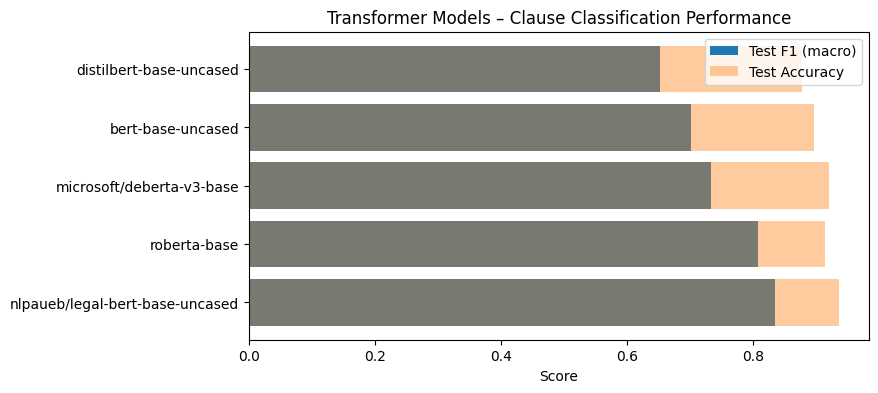


🏆 Best model: nlpaueb/legal-bert-base-uncased
model             nlpaueb/legal-bert-base-uncased
val_f1                                   0.855176
val_acc                                  0.932203
test_f1                                  0.834018
test_acc                                 0.936441
test_precision                           0.860726
test_recall                               0.82632
Name: 0, dtype: object


In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.barh(df_results["model"], df_results["test_f1"], label="Test F1 (macro)")
plt.barh(df_results["model"], df_results["test_acc"], alpha=0.4, label="Test Accuracy")
plt.xlabel("Score")
plt.title("Transformer Models – Clause Classification Performance")
plt.legend()
plt.show()

best_model = df_results.sort_values("test_f1", ascending=False).iloc[0]
print(f"\n🏆 Best model: {best_model['model']}")
print(best_model)


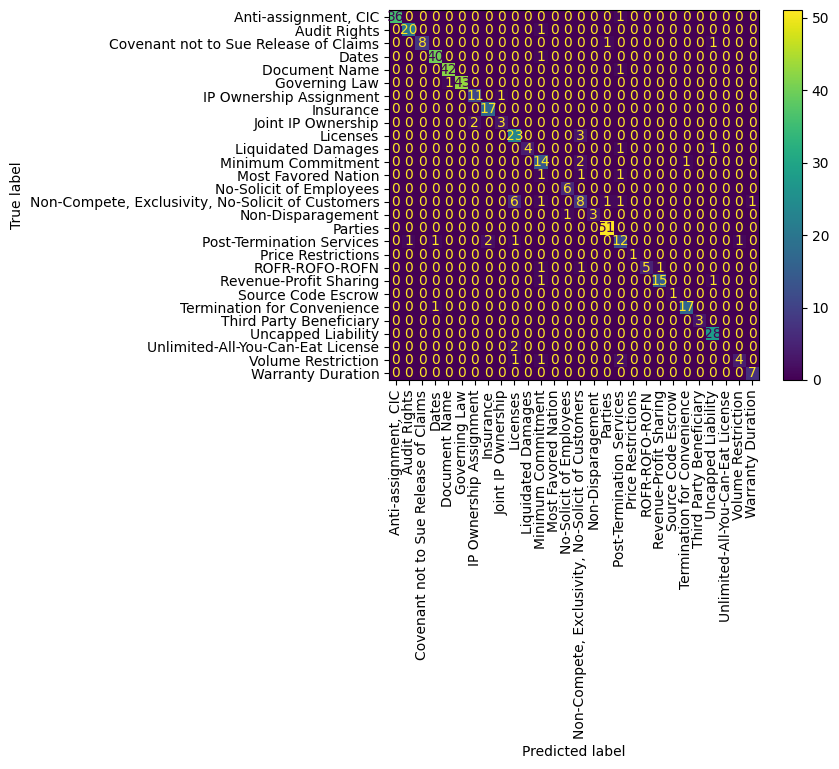

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(
    yte, y_pred_test,
    display_labels=[id2label[i] for i in range(len(id2label))],
    xticks_rotation=90
)


In [24]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from pathlib import Path
import json

assert len(df_results), "No successful runs found."
best_row = df_results.sort_values("test_f1", ascending=False).iloc[0]
best_model_name = best_row["model"]
print(f"🏆 Best model: {best_model_name}  |  test_f1={best_row['test_f1']:.4f}")

SAVE_DIR = Path("./best_clause_model")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

tok = AutoTokenizer.from_pretrained(best_model_name, use_fast=True)
model = AutoModelForSequenceClassification.from_pretrained(
    best_model_name,
    num_labels=len(id2label),
    id2label=id2label,
    label2id={v:k for k,v in id2label.items()}
)
model.save_pretrained(SAVE_DIR)
tok.save_pretrained(SAVE_DIR)
with open(SAVE_DIR / "label_mapping.json", "w") as f:
    json.dump({"id2label": id2label, "label2id": {v:k for k,v in id2label.items()}}, f, indent=2)

print("✅ Saved to:", SAVE_DIR.resolve())


🏆 Best model: nlpaueb/legal-bert-base-uncased  |  test_f1=0.8340


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Saved to: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/best_clause_model


In [25]:
summary = df_results.sort_values("test_f1", ascending=False)
print("=== Overall Summary ===")
print(summary[["model", "val_f1", "test_f1", "test_acc", "test_precision", "test_recall"]])

best = summary.iloc[0]
print(f"\n✅ The best transformer is **{best['model']}** "
      f"with Test F1={best['test_f1']:.3f}, "
      f"Accuracy={best['test_acc']:.3f}, "
      f"Precision={best['test_precision']:.3f}, "
      f"Recall={best['test_recall']:.3f}.")


=== Overall Summary ===
                             model    val_f1   test_f1  test_acc  \
0  nlpaueb/legal-bert-base-uncased  0.855176  0.834018  0.936441   
2                     roberta-base  0.778188  0.807443  0.913136   
4        microsoft/deberta-v3-base  0.746642  0.732112  0.919492   
1                bert-base-uncased  0.708681  0.701483  0.896186   
3          distilbert-base-uncased  0.647722  0.651131  0.877119   

   test_precision  test_recall  
0        0.860726     0.826320  
2        0.836576     0.798711  
4        0.738830     0.737851  
1        0.715255     0.705657  
3        0.674684     0.658206  

✅ The best transformer is **nlpaueb/legal-bert-base-uncased** with Test F1=0.834, Accuracy=0.936, Precision=0.861, Recall=0.826.


In [26]:
%pip install protobuf

Note: you may need to restart the kernel to use updated packages.


In [27]:
%pip install mlflow

Note: you may need to restart the kernel to use updated packages.


In [28]:
# === Multi-backbone, script-style trainer (exports under .../model + metrics JSONs) — DeBERTa fixed ===
import os, re, json, time, inspect, subprocess, sys, traceback
from pathlib import Path
from typing import Dict, List

import numpy as np
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

# --------------------- Global config (matches your script semantics) ---------------------
SEED        = 42
MAX_LENGTH  = 160
BATCH       = 1
GRAD_ACCUM  = 8
LR          = 2e-5
EPOCHS      = 3

# The exact set you ran previously
BACKBONES: List[str] = [
    "nlpaueb/legal-bert-base-uncased",
    "bert-base-uncased",
    "roberta-base",
    "distilbert-base-uncased",
    "microsoft/deberta-v3-base",  # needs sentencepiece; handled below
]

# Output layout identical to your script
NOTEBOOK_ROOT = Path.cwd()
OUT_ROOT = (NOTEBOOK_ROOT / "outputs_models")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

def ts() -> str:
    return time.strftime("%Y%m%d_%H%M%S")

# macOS MPS watermarks as in your script
os.environ.setdefault("PYTORCH_MPS_HIGH_WATERMARK_RATIO", "0.9")
os.environ.setdefault("PYTORCH_MPS_LOW_WATERMARK_RATIO", "0.5")

print(f"Torch: {torch.__version__}")
device = "mps" if torch.backends.mps.is_available() else ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
if device == "mps":
    print(f"MPS high watermark: {os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO']}")
    print(f"MPS low  watermark: {os.environ['PYTORCH_MPS_LOW_WATERMARK_RATIO']}")

# --------------------- Dataset + metrics (script-accurate) ---------------------
class ClauseDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, tokenizer, max_length: int):
        assert "ClauseText" in df.columns, "Expected 'ClauseText' in dataframe."
        assert "label" in df.columns, "Expected 'label' int column in dataframe."
        self.texts = df["ClauseText"].astype(str).tolist()
        self.labels = df["label"].astype(int).tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self): return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",     # **match the script**
            max_length=self.max_length,
            return_tensors="pt",
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    if isinstance(logits, (list, tuple)): logits = logits[0]
    preds = logits.argmax(axis=-1)
    return {"macro_f1": f1_score(labels, preds, average="macro"),
            "accuracy": accuracy_score(labels, preds)}

# --------------------- HF version-safe TrainingArguments ---------------------
def make_training_args(run_dir: Path, *, lr, batch, grad_accum, epochs, seed=SEED):
    """
    Mirrors your script: no evaluation during training, logging_steps every 50,
    no checkpoint saving during train. Compatible with older Transformers.
    """
    cand = dict(
        output_dir=str(run_dir / "hf_runs"),
        per_device_train_batch_size=batch,
        per_device_eval_batch_size=batch,
        gradient_accumulation_steps=grad_accum,
        num_train_epochs=epochs,
        learning_rate=lr,
        warmup_ratio=0.06,
        weight_decay=0.01,
        logging_steps=50,
        save_strategy="no",
        report_to="none",
        remove_unused_columns=False,
        dataloader_num_workers=0,
        seed=seed,
    )
    sig = inspect.signature(TrainingArguments.__init__)
    safe = {k: v for k, v in cand.items() if k in sig.parameters}
    return TrainingArguments(**safe)

# --------------------- Optional MLflow (auto-install if missing) ---------------------
def ensure_mlflow():
    try:
        import mlflow  # noqa
        return True
    except ImportError:
        print("[MLflow] Not found; attempting a lightweight install…")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "mlflow"])
            import mlflow  # noqa
            print("[MLflow] Installed and ready.")
            return True
        except Exception as e:
            print(f"[MLflow] Install failed, will skip logging. Reason: {e}")
            return False

MLFLOW_OK = ensure_mlflow()

def log_to_mlflow(params: Dict, metrics: Dict, artifacts_dir: Path):
    if not MLFLOW_OK:
        print("[MLflow] Skipped logging (module not available).")
        return
    try:
        import mlflow
        mlflow.set_experiment("clause-classifier")
        with mlflow.start_run():
            mlflow.log_params(params)
            mlflow.log_metrics(metrics)
            mlflow.log_artifacts(str(artifacts_dir))
        print("Logged to MLflow experiment 'clause-classifier'.")
    except Exception as e:
        print(f"[MLflow] Logging error (skipped): {e}")

# --------------------- DeBERTa-v3 dependency helper ---------------------
def ensure_sentencepiece():
    try:
        import sentencepiece  # noqa
        return True
    except Exception:
        print("[DeBERTa] sentencepiece not found; attempting install…")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", "sentencepiece>=0.1.99", "protobuf>=3.20"])
            import sentencepiece  # noqa
            print("[DeBERTa] sentencepiece installed.")
            return True
        except Exception as e:
            print(f"[DeBERTa] Could not install sentencepiece; will skip DeBERTa-v3. Reason: {e}")
            return False

# --------------------- Single-backbone train/eval/export (script-accurate) ---------------------
def train_and_eval_single_backbone(
    df_train: pd.DataFrame,
    df_val: pd.DataFrame,
    df_test: pd.DataFrame,
    id2label: Dict[int, str],
    *,
    model_name: str,
    max_length: int = MAX_LENGTH,
    batch: int = BATCH,
    grad_accum: int = GRAD_ACCUM,
    lr: float = LR,
    epochs: int = EPOCHS,
    out_dir: Path = None,
) -> Dict:
    num_labels = len(id2label)
    label2id = {v: k for k, v in id2label.items()}

    if out_dir is None:
        out_dir = OUT_ROOT / f"{ts()}_{Path(model_name).name}_lr{lr:.0e}_ep{epochs}"
    (out_dir / "model").mkdir(parents=True, exist_ok=True)

    # Tokenizer/model (special handling for DeBERTa-v3)
    if model_name == "microsoft/deberta-v3-base":
        ok = ensure_sentencepiece()
        if not ok:
            raise RuntimeError("sentencepiece is required for microsoft/deberta-v3-base and could not be installed.")
        tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, trust_remote_code=True)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, trust_remote_code=True
        )
    else:
        try:
            tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        except Exception as e:
            print(f"[Tokenizer] Falling back to slow tokenizer for {model_name}: {e}")
            tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, trust_remote_code=True)
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, id2label=id2label, label2id=label2id, trust_remote_code=True
        )

    train_ds = ClauseDataset(df_train, tokenizer, max_length)
    val_ds   = ClauseDataset(df_val, tokenizer, max_length)
    test_ds  = ClauseDataset(df_test, tokenizer, max_length)

    args = make_training_args(
        run_dir=out_dir, lr=lr, batch=batch, grad_accum=grad_accum, epochs=epochs, seed=SEED
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,   # not auto-evaluated during training; used for predict()
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Train exactly like the script (no eval during training)
    trainer.train()

    def eval_to_dict(ds: ClauseDataset):
        out = trainer.predict(ds)
        y_true = out.label_ids
        logits = out.predictions[0] if isinstance(out.predictions, tuple) else out.predictions
        y_pred = logits.argmax(-1)
        rep = classification_report(
            y_true, y_pred,
            target_names=[id2label[i] for i in range(num_labels)],
            digits=4, output_dict=True, zero_division=0
        )
        cm = confusion_matrix(y_true, y_pred).tolist()
        return {"report": rep, "confusion_matrix": cm}

    res_train = eval_to_dict(train_ds)
    res_val   = eval_to_dict(val_ds)
    res_test  = eval_to_dict(test_ds)

    # Save model export under out_dir / model
    model.save_pretrained(out_dir / "model")
    tokenizer.save_pretrained(out_dir / "model")

    # Save metrics JSONs
    with open(out_dir / "metrics_train.json", "w") as f:
        json.dump(res_train, f, indent=2)
    with open(out_dir / "metrics_val.json", "w") as f:
        json.dump(res_val, f, indent=2)
    with open(out_dir / "metrics_test.json", "w") as f:
        json.dump(res_test, f, indent=2)

    # Single-row CSV appended to OUT_ROOT with a timestamped name (consistent with script)
    row = dict(
        model=model_name,
        epochs=epochs,
        learning_rate=lr,
        max_length=max_length,
        batch=batch,
        grad_accum=grad_accum,
        val_macro_f1=res_val["report"]["macro avg"]["f1-score"],
        val_accuracy=res_val["report"]["accuracy"],
        test_macro_f1=res_test["report"]["macro avg"]["f1-score"],
        test_accuracy=res_test["report"]["accuracy"],
        out_dir=str(out_dir),
    )
    single_csv = OUT_ROOT / f"final_report_{ts()}.csv"
    pd.DataFrame([row]).to_csv(single_csv, index=False)

    # MLflow (if available)
    log_to_mlflow(
        params={
            "lr": lr, "epochs": epochs, "max_length": max_length,
            "batch": batch, "grad_accum": grad_accum, "base_model": model_name
        },
        metrics={
            "val_macro_f1": row["val_macro_f1"], "val_acc": row["val_accuracy"],
            "test_macro_f1": row["test_macro_f1"], "test_acc": row["test_accuracy"]
        },
        artifacts_dir=(out_dir / "model"),
    )

    print(f"Saved CSV: {single_csv}")
    print(f"Saved model export under: {out_dir}/model")

    return row

# --------------------- Run all backbones and build a leaderboard ---------------------
def train_all_backbones(
    backbones: List[str],
    train_df, val_df, test_df, id2label,
    *,
    max_length=MAX_LENGTH, batch=BATCH, grad_accum=GRAD_ACCUM, lr=LR, epochs=EPOCHS
) -> pd.DataFrame:
    results = []
    for name in backbones:
        print("\n" + "="*88)
        print(f"▶ Training backbone: {name}")
        try:
            row = train_and_eval_single_backbone(
                train_df, val_df, test_df, id2label,
                model_name=name,
                max_length=max_length,
                batch=batch,
                grad_accum=grad_accum,
                lr=lr,
                epochs=epochs,
                out_dir=None,  # timestamped dir under outputs_models/
            )
            results.append(row)
        except Exception as e:
            print(f"[SKIP] {name}: {e}")
            failure_log = OUT_ROOT / "_failures"
            failure_log.mkdir(parents=True, exist_ok=True)
            with open(failure_log / f"{ts()}_{Path(name).name}.log", "w") as f:
                f.write("".join(traceback.format_exception(type(e), e, e.__traceback__)))

    if not results:
        print("❗ No successful runs.")
        return pd.DataFrame()

    df_leader = pd.DataFrame(results).sort_values("test_macro_f1", ascending=False)
    leaderboard_csv = OUT_ROOT / f"models_leaderboard_{ts()}.csv"
    df_leader.to_csv(leaderboard_csv, index=False)
    print(f"\nLeaderboard saved: {leaderboard_csv}")
    display(df_leader[["model", "val_macro_f1", "val_accuracy", "test_macro_f1", "test_accuracy", "out_dir"]])
    return df_leader

# === Kick off the multi-model training (uses your existing train/val/test splits) ===
_ = train_all_backbones(
    BACKBONES,
    train_df, val_df, test_df, id2label,
    max_length=MAX_LENGTH, batch=BATCH, grad_accum=GRAD_ACCUM, lr=LR, epochs=EPOCHS
)


Torch: 2.6.0
Device: mps
MPS high watermark: 0.90
MPS low  watermark: 0.50



▶ Training backbone: nlpaueb/legal-bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/2152187728.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': None}.


Step,Training Loss
50,3.294600
100,2.996300
150,2.336700
200,1.683700
250,1.252100
300,0.818100
350,0.784100
400,0.642000
450,0.611200
500,0.410200


Logged to MLflow experiment 'clause-classifier'.
Saved CSV: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/final_report_20251012_235035.csv
Saved model export under: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/20251012_233904_legal-bert-base-uncased_lr2e-05_ep3/model

▶ Training backbone: bert-base-uncased


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/2152187728.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.292400
100,2.992100
150,2.465700
200,1.916100
250,1.612300
300,1.228600
350,1.105800
400,1.006300
450,0.884600
500,0.688100


Logged to MLflow experiment 'clause-classifier'.
Saved CSV: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/final_report_20251013_000145.csv
Saved model export under: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/20251012_235036_bert-base-uncased_lr2e-05_ep3/model

▶ Training backbone: roberta-base


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/2152187728.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.310500
100,2.821800
150,1.769500
200,1.118300
250,1.004700
300,0.776300
350,0.769500
400,0.656200
450,0.594400
500,0.434000


Logged to MLflow experiment 'clause-classifier'.
Saved CSV: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/final_report_20251013_001327.csv
Saved model export under: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/20251013_000145_roberta-base_lr2e-05_ep3/model

▶ Training backbone: distilbert-base-uncased


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/2152187728.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Step,Training Loss
50,3.276600
100,2.904500
150,2.220700
200,1.685600
250,1.511500
300,1.184000
350,1.097200
400,1.035600
450,0.900300
500,0.700500


Logged to MLflow experiment 'clause-classifier'.
Saved CSV: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/final_report_20251013_001954.csv
Saved model export under: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/20251013_001327_distilbert-base-uncased_lr2e-05_ep3/model

▶ Training backbone: microsoft/deberta-v3-base


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/qy/lb5596t96sd6y85j3bzzwkp00000gn/T/ipykernel_47362/2152187728.py:209: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Step,Training Loss
50,3.330700
100,2.943300
150,2.238300
200,1.689500
250,1.550300
300,1.198500
350,1.086600
400,1.019100
450,0.927500
500,0.683200


Logged to MLflow experiment 'clause-classifier'.
Saved CSV: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/final_report_20251013_003849.csv
Saved model export under: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/20251013_001954_deberta-v3-base_lr2e-05_ep3/model

Leaderboard saved: /Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AICRA/Clause_classifier/outputs_models/models_leaderboard_20251013_003849.csv


,model,val_macro_f1,val_accuracy,test_macro_f1,test_accuracy,out_dir
0,nlpaueb/legal-bert-base-uncased,0.793090,0.915254,0.810501,0.919492,/Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AI...
2,roberta-base,0.776170,0.917373,0.748803,0.906780,/Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AI...
4,microsoft/deberta-v3-base,0.664169,0.887712,0.713614,0.902542,/Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AI...
1,bert-base-uncased,0.676130,0.875000,0.685196,0.885593,/Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AI...
3,distilbert-base-uncased,0.651850,0.866525,0.672232,0.879237,/Users/sruthynath/Mac Docs/MPSTME/LTIM/LTIM_AI...
